In [1]:
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt

import io
import numpy as np
from six import BytesIO
import cv2
from PIL import Image
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# Utilities and Helper Functions

In [22]:
def load_image_into_array(path):
  image = None
  if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
  else:
      image_data = tf.io.gfile.GFile(path, 'rb').read()
      image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)

In [8]:
category_index =  \
{
         1: 'person',
         2: 'bicycle',
         3: 'car',
         4: 'motorcycle',
         5: 'airplane',
         6: 'bus',
         7: 'train',
         8: 'truck',
         9: 'boat',
         10: 'traffic light',
         11: 'fire hydrant',
         13: 'stop sign',
         14: 'parking meter',
         15: 'bench',
         16: 'bird',
         17: 'cat',
         18: 'dog',
         19: 'horse',
         20: 'sheep',
         21: 'cow',
         22: 'elephant',
         23: 'bear',
         24: 'zebra',
         25: 'giraffe',
         27: 'backpack',
         28: 'umbrella',
         31: 'handbag',
         32: 'tie',
         33: 'suitcase',
         34: 'frisbee',
         35: 'skis',
         36: 'snowboard',
         37: 'sports ball',
         38: 'kite',
         39: 'baseball bat',
         40: 'baseball glove',
         41: 'skateboard',
         42: 'surfboard',
         43: 'tennis racket',
         44: 'bottle',
         46: 'wine glass',
         47: 'cup',
         48: 'fork',
         49: 'knife',
         50: 'spoon',
         51: 'bowl',
         52: 'banana',
         53: 'apple',
         54: 'sandwich',
         55: 'orange',
         56: 'broccoli',
         57: 'carrot',
         58: 'hot dog',
         59: 'pizza',
         60: 'donut',
         61: 'cake',
         62: 'chair',
         63: 'couch',
         64: 'potted plant',
         65: 'bed',
         67: 'dining table',
         70: 'toilet',
         72: 'tv',
         73: 'laptop',
         74: 'mouse',
         75: 'remote',
         76: 'keyboard',
         77: 'cell phone',
         78: 'microwave',
         79: 'oven',
         80: 'toaster',
         81: 'sink',
         82: 'refrigerator',
         84: 'book',
         85: 'clock',
         86: 'vase',
         87: 'scissors',
         88: 'teddy bear',
         89: 'hair drier',
         90: 'toothbrush'

}

In [10]:
R = np.array(np.arange(0,256,32))
G=np.roll(R,2)
B=np.roll(R,4)

COLOR_IDS = np.array(np.meshgrid(R,G,B)).T.reshape(-1,3)

In [11]:
# SSD Model Inference using Tensorflow Hub

In [12]:
SSD_Resnet    = {'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)'    : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
                 'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)'  : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
                 'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)'  : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
                 'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)': 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
                 'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)'  : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
                 'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)': 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1'
                }

SSD_Mobilenet = {'SSD MobileNet v2 320x320'         : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
                 'SSD MobileNet V1 FPN 640x640'     : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
                 'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
                 'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1'
                }

EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }

image_urls   = ['http://images.cocodataset.org/test2017/000000550803.jpg',
                'http://images.cocodataset.org/test2017/000000004053.jpg',
                'http://images.cocodataset.org/test2017/000000426603.jpg',
                'http://images.cocodataset.org/val2017/000000007088.jpg'
               ]

In [13]:
model_display_name_1 = 'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)'
model_handle_1 = SSD_Resnet[model_display_name_1]

print('Selected model:'+ model_display_name_1)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle_1))

model_display_name_2 = 'SSD MobileNet V1 FPN 640x640'
model_handle_2 = SSD_Mobilenet[model_display_name_2]

print('Selected model:'+ model_display_name_2)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle_2))

model_display_name_3 = 'EfficientDet D1 640x640'
model_handle_3 = EfficientDet[model_display_name_3]

print('Selected model:'+ model_display_name_3)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle_3))

Selected model:SSD ResNet50 V1 FPN 640x640 (RetinaNet50)
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1
Selected model:SSD MobileNet V1 FPN 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1
Selected model:EfficientDet D1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/efficientdet/d1/1


In [14]:
# Loding the Model from the Hub

In [15]:
print('loading model_1...')
hub_model_1 = hub.load(model_handle_1)
print('model_1 loaded')

print('loading model_2...')
hub_model_2 = hub.load(model_handle_2)
print('model_2 loaded')

print('loading model_3...')
hub_model_3 = hub.load(model_handle_3)
print('model_3 loaded')

loading model_1...
model_1 loaded
loading model_2...
model_2 loaded
loading model_3...


model_3 loaded


In [16]:
# Load Sample Images

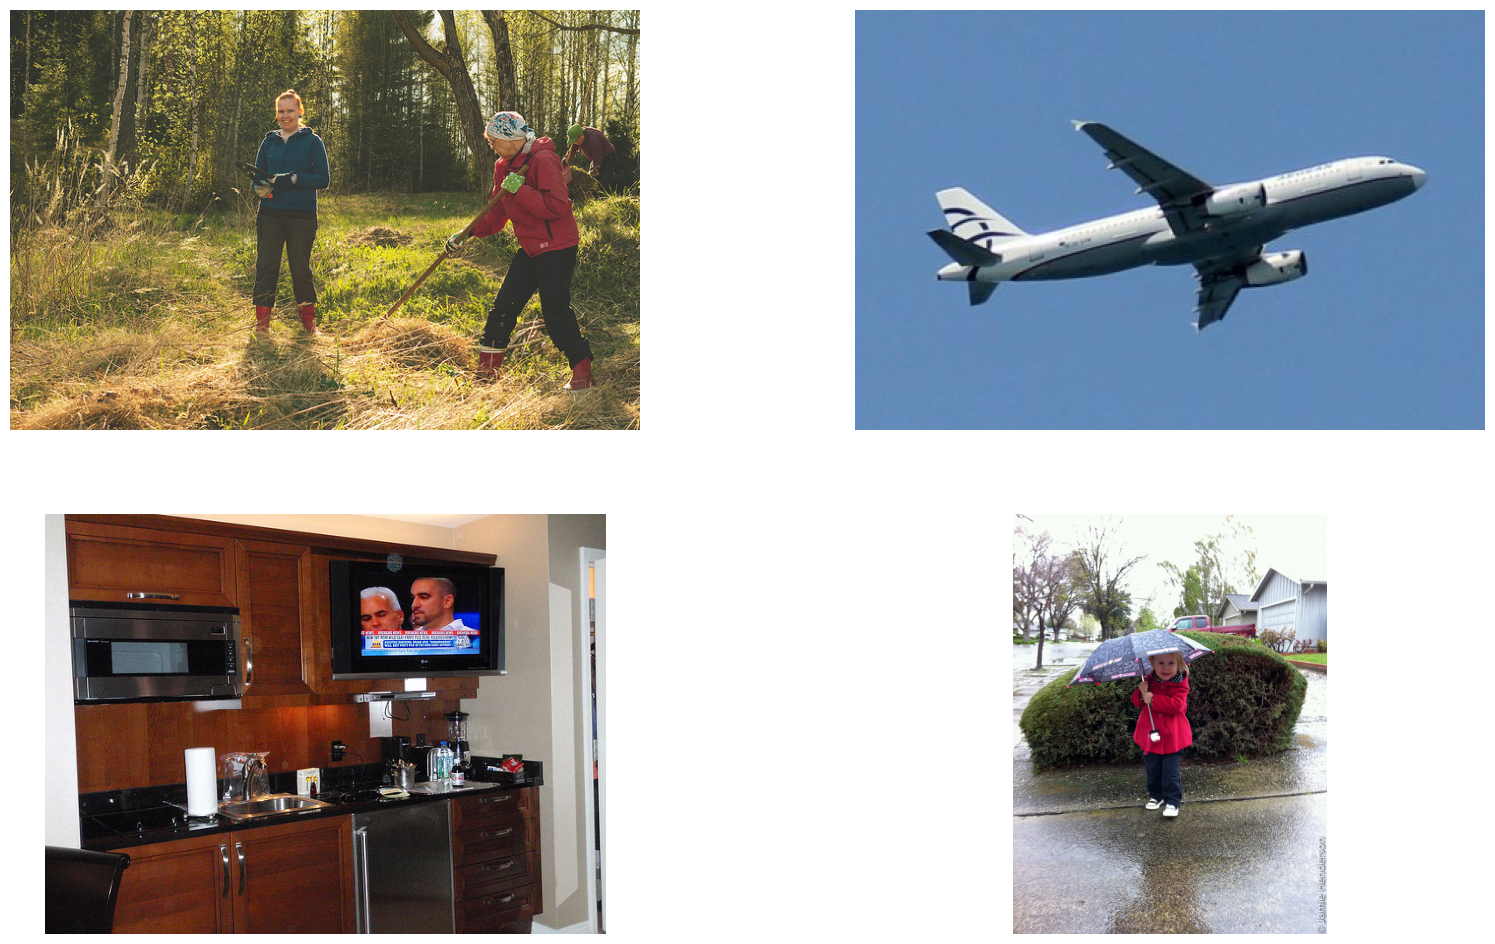

In [25]:
images = []
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

idx = 0
for axis in ax.flat:
  image_np = load_image_into_array(image_urls[idx])
  images.append(image_np)
  axis.imshow(image_np[0])
  axis.axis('off')
  idx += 1

plt.show(block = False)

In [26]:
# Performance Inference

In [27]:
def run_inference(images, model):
  results_final = []
  for img in images:
    results = model(img)
    result = {key:value.numpy() for key, value in results.items()}

    results_final.append(result)

  return results_final

In [28]:
# Inference from ResNet101
results_final_1 = run_inference(images, hub_model_1)

In [29]:
# Inference from SSD MobileNet v1 with FPM
results_final_2 =  run_inference(images, hub_model_2)

In [30]:
# Inference from EfficeintNet
results_final_3 =  run_inference(images, hub_model_3)

In [32]:
print(results_final_1[0].keys())

dict_keys(['raw_detection_boxes', 'detection_multiclass_scores', 'detection_classes', 'detection_boxes', 'raw_detection_scores', 'num_detections', 'detection_anchor_indices', 'detection_scores'])


In [33]:
# Visulaize the Results

In [40]:
def visualize_per_image(image, boxes, classes, scores, cat_id, min_score_thresh=.30):

    ids = np.where(scores >= min_score_thresh)[0]

    boxes_thres = boxes[ids]
    classes_thres = classes[ids]
    scores_thres = scores[ids]

    img_bbox = image.copy()
    im_height, im_width = image.shape[:2]

    for box, cls, score in zip(boxes_thres, classes_thres, scores_thres):

        ymin, xmin, ymax, xmax = box
        class_name = cat_id[cls]
        (left, right, top, bottom) = (int(xmin * im_width), int(xmax * im_width),  int(ymin * im_height), int(ymax * im_height))

        color = tuple(COLOR_IDS[cls % len(COLOR_IDS)].tolist())[::-1]

        img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=2)

        display_txt = '{}: {:.2f}%'.format(class_name, 100*score)

        ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)


        img_bbox = cv2.rectangle(img_bbox, (left, top - int(0.9 * text_height)), (left + int(0.4*text_width), top), color, thickness=-1)


        img_bbox = cv2.putText(img_bbox, display_txt,
                (left, top - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)


    return img_bbox

In [41]:
def visualize_results(images, results_final, title):

    label_id_offset = 0

    plt.figure(figsize=[20, 12])
    plt.suptitle(title, fontsize=24)

    idx=0
    for idx, img_plt in enumerate(images):
        image_np_with_detections = img_plt.copy()
        image_bbox = visualize_per_image(
                image_np_with_detections[0],
                results_final[idx]['detection_boxes'][0],
                (results_final[idx]['detection_classes'][0]).astype(int),
                results_final[idx]['detection_scores'][0],
                category_index,
                min_score_thresh=.30,
                )

        plt.subplot(2,2,idx+1);
        plt.imshow(image_bbox)
        plt.axis('off')


    plt.show(block=False)

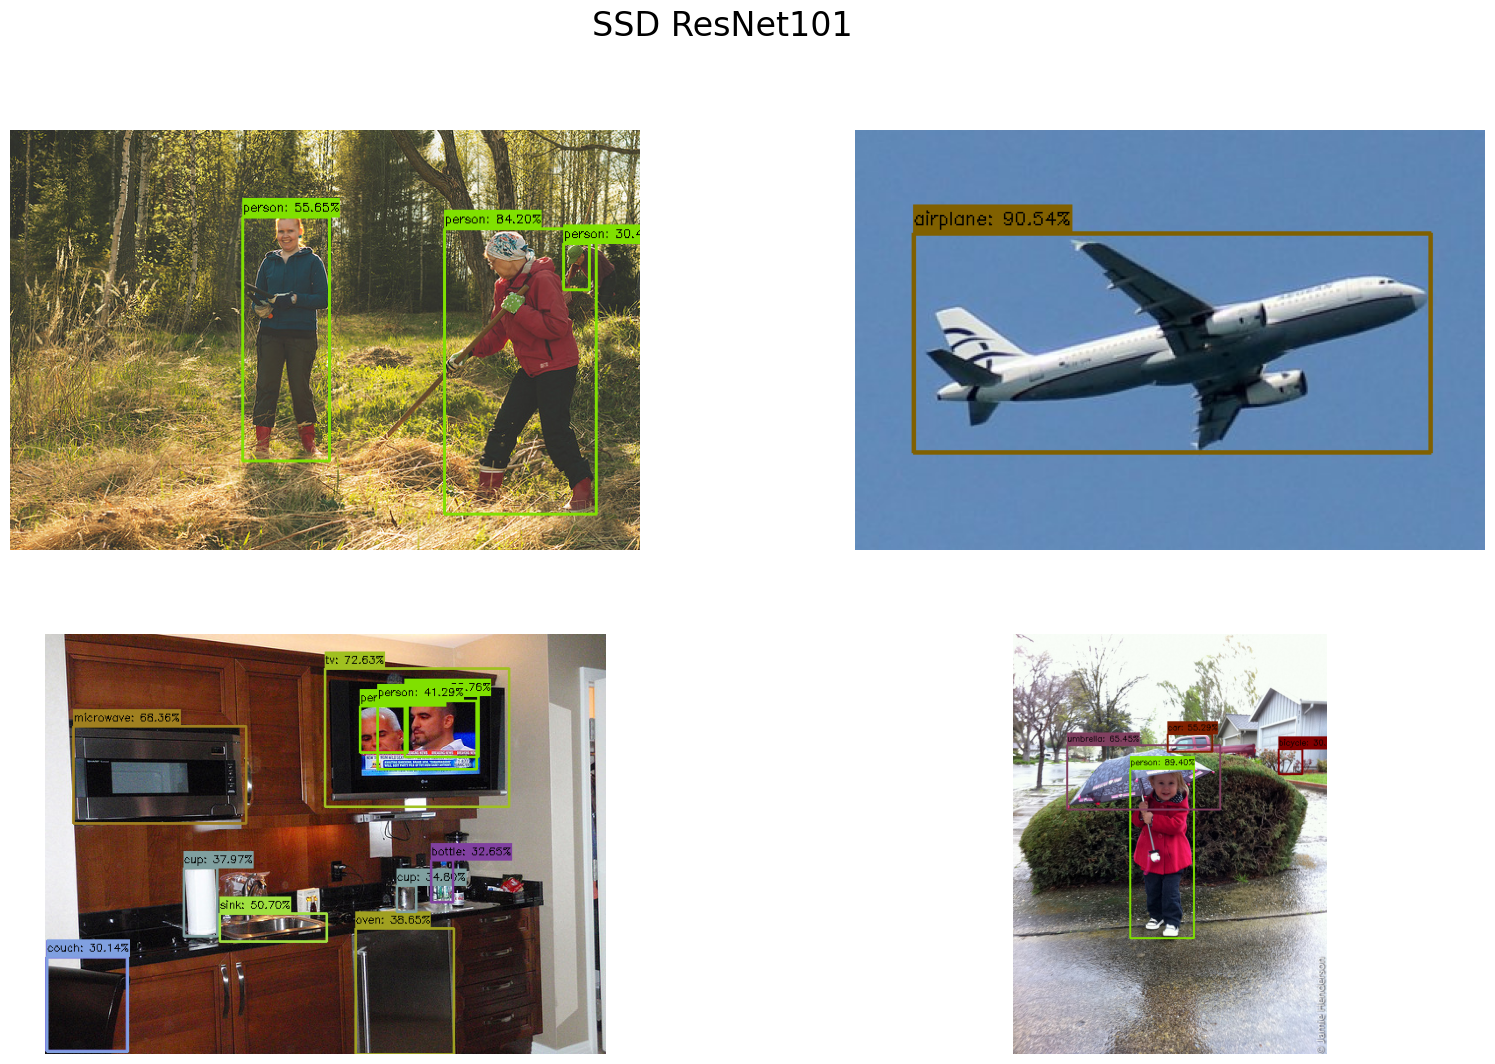

In [42]:
visualize_results(images, results_final_1, title='SSD ResNet101')

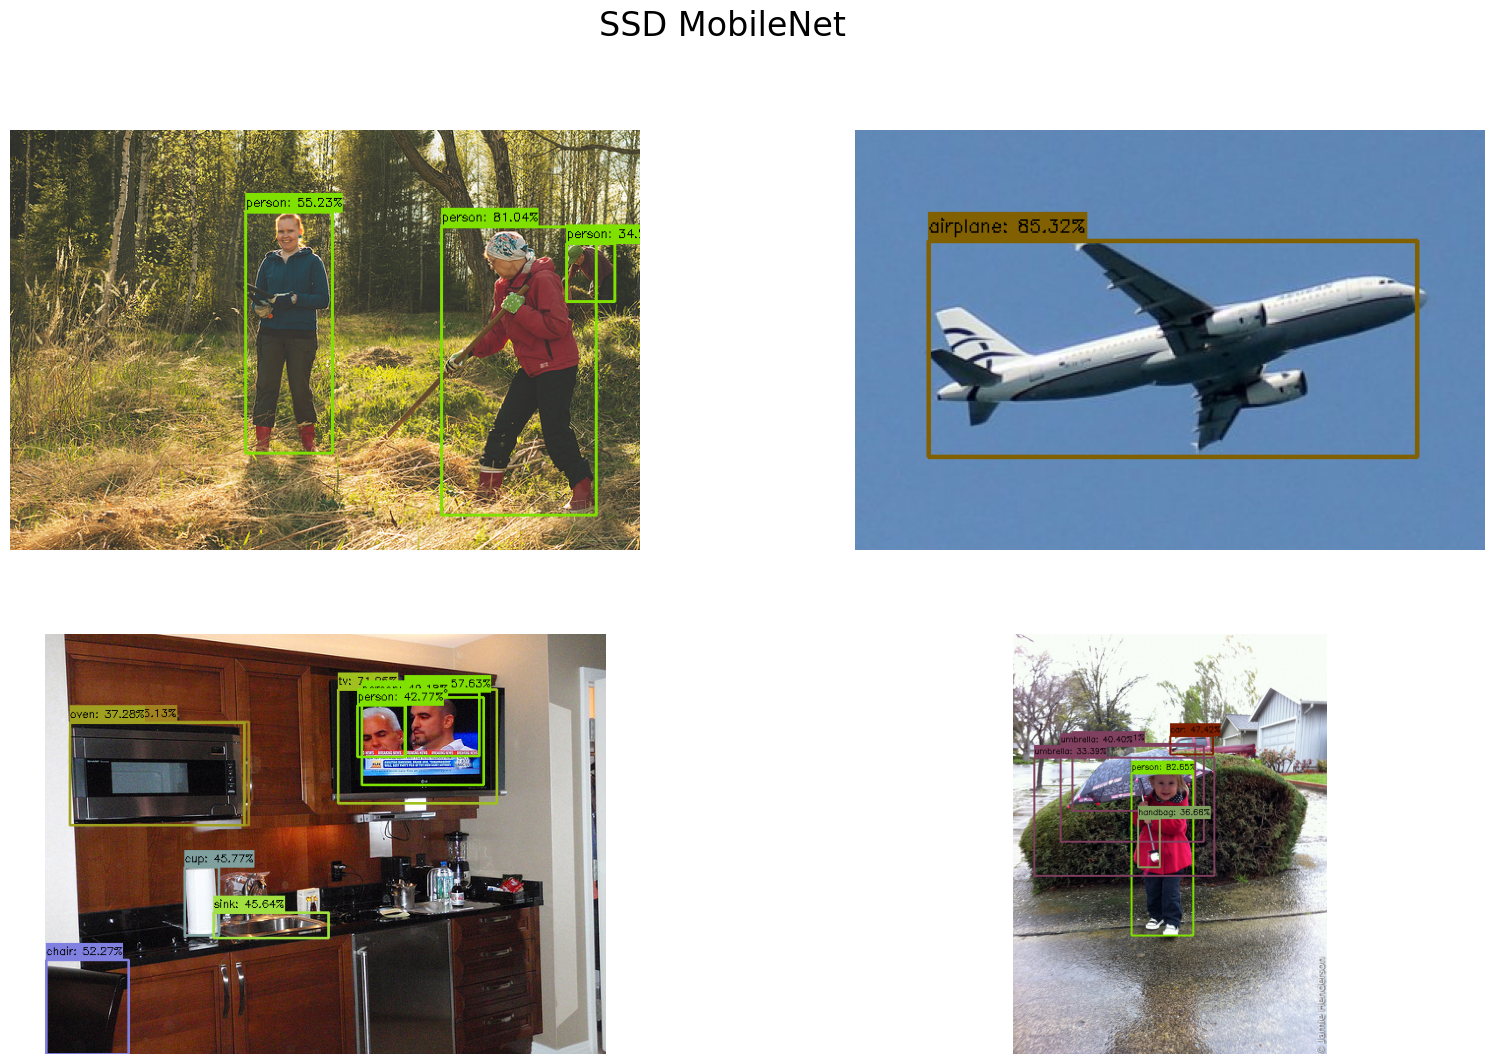

In [43]:
visualize_results(images, results_final_2, title='SSD MobileNet')

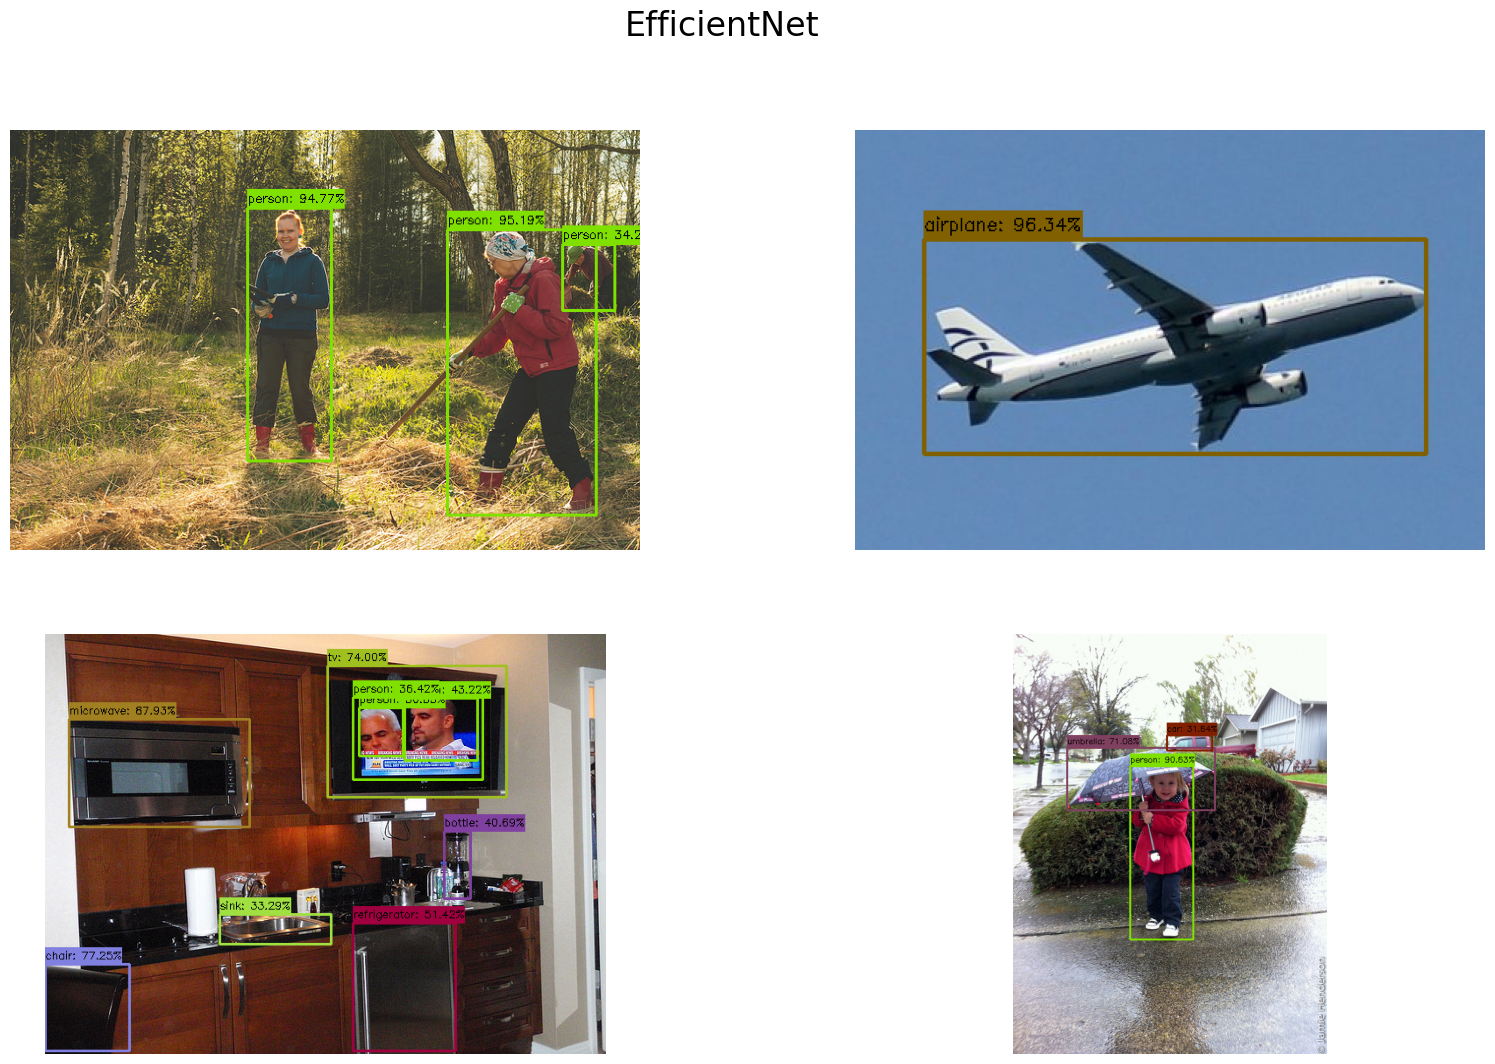

In [44]:
visualize_results(images, results_final_3, title='EfficientNet')